# Histopathologic Cancer Detection Mini-Project

## Overview
This project is part of a Kaggle competition aimed at building a binary image classification model to detect metastatic cancer in small image patches taken from larger digital pathology scans. The primary goal is to develop a convolutional neural network (CNN) that can classify these images as either **cancerous (1)** or **non-cancerous (0)**.

## Objectives
1. Preprocess the dataset to prepare it for model training.
2. Explore and visualize the data to gain insights.
3. Design, train, and evaluate a CNN model to classify the images.
4. Optimize the model using hyperparameter tuning and other techniques.
5. Submit the results to Kaggle and analyze the model's performance.

## Dataset
- **Training Images**: 50x50 pixel image patches in `.tif` format.
- **Labels**: Binary labels (`1` for cancerous, `0` for non-cancerous) provided in a CSV file.
- **Test Images**: Images without labels for generating predictions to submit to Kaggle.

## Workflow
This notebook is structured as follows:
1. **Installing Required Libraries**
2. **Loading and Preprocessing the Data**
3. **Exploratory Data Analysis (EDA)**
4. **Model Design and Training**
5. **Results and Analysis**
6. **Submission to Kaggle**
7. **Conclusion**

By following this workflow, we aim to build an effective and optimized classification model while documenting each step for reproducibility and peer review.


##  Installing Required Libraries

Before starting the project, we need to ensure all the necessary libraries are installed. These libraries will help us with:

1. **Data Handling**:
   - **`pandas`**: For working with tabular data, such as reading the `train_labels.csv` file.
   - **`numpy`**: For handling numerical data and arrays.

2. **Data Visualization**:
   - **`matplotlib`** and **`seaborn`**: For creating plots and visualizations to understand the data better.

3. **Image Processing**:
   - **`opencv-python`**: For reading and manipulating image data.

4. **Deep Learning**:
   - **`tensorflow`** and **`keras`**: For building and training the convolutional neural network (CNN).

5. **Kaggle API**:
   - **`kaggle`**: For downloading datasets directly from Kaggle competitions.

The following command installs all these libraries in one step:
```python
!pip install kaggle numpy pandas matplotlib seaborn scikit-learn tensorflow keras opencv-python


In [16]:
# Install required libraries for the project
!pip install kaggle numpy pandas matplotlib seaborn scikit-learn tensorflow keras opencv-python


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Loading and Preprocessing the Data

In this step, we load the dataset and preprocess it for training the model. The process includes:

1. **Defining Parameters**:
   - All images will be resized to 50x50 pixels to ensure consistent input dimensions for the model.
   - The dataset directory, training image directory, and labels file are defined.

2. **Loading the Labels**:
   - The labels file `train_labels.csv` is loaded using Pandas. This file contains image IDs and their corresponding labels (0 or 1).

3. **Processing the Images**:
   - Each image is loaded from the training directory using the image ID from the labels file.
   - Images are resized to 50x50 pixels and normalized to have pixel values in the range `[0, 1]`.

4. **Storing Data**:
   - Processed images are stored in a NumPy array (`X`), and their corresponding labels are stored in another NumPy array (`y`).

Finally, we display:
- The total number of images loaded.
- The dimensions of each image in the dataset.


In [17]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Parameters
IMG_SIZE = 50  # Resize all images to 50x50 pixels
DATA_DIR = "dataset"  # Base directory for the dataset
TRAIN_DIR = os.path.join(DATA_DIR, "train")  # Directory containing training images
LABELS_FILE = os.path.join(DATA_DIR, "train_labels.csv")  # Path to the labels CSV file

# Load the labels
labels = pd.read_csv(LABELS_FILE)

# Load images and their corresponding labels
images = []
targets = []
for idx, row in labels.iterrows():
    image_path = os.path.join(TRAIN_DIR, f"{row['id']}.tif")
    if os.path.exists(image_path):  # Ensure the file exists
        img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))  # Load and resize the image
        img_array = img_to_array(img) / 255.0  # Convert image to array and normalize pixel values
        images.append(img_array)
        targets.append(row['label'])

# Convert to NumPy arrays
X = np.array(images)
y = np.array(targets)

# Display dataset information
print(f"Total number of images: {X.shape[0]}")
print(f"Image dimensions: {X.shape[1:]}")


Total number of images: 220025
Image dimensions: (50, 50, 3)


## Exploratory Data Analysis (EDA)

Before training the model, it is essential to understand the dataset through visualizations and basic statistical analysis.
EDA helps us answer key questions such as:
- What is the distribution of labels (cancerous vs. non-cancerous)?
- Are there any class imbalances in the dataset?
- What do sample images from each class look like?

The following analysis will include:
1. **Label Distribution Visualization**
2. **Sample Images from the Dataset**
3. **Pixel Intensity Histogram**


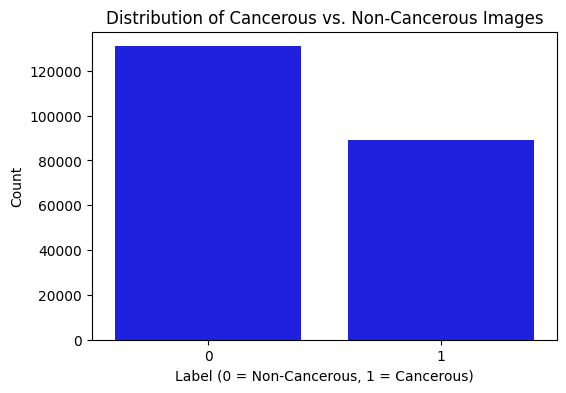

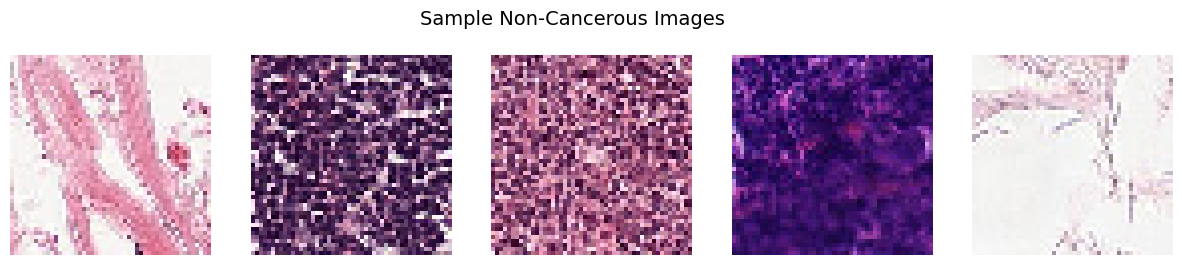

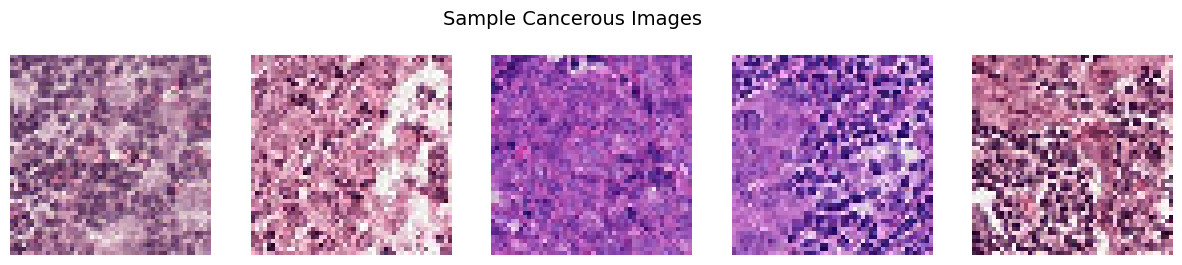

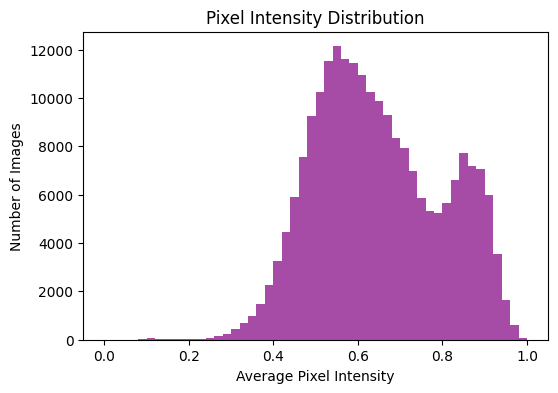

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

# 1. Visualizing Label Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=labels, x='label', color='blue')
plt.title("Distribution of Cancerous vs. Non-Cancerous Images")
plt.xlabel("Label (0 = Non-Cancerous, 1 = Cancerous)")
plt.ylabel("Count")
plt.show()

# 2. Display Sample Images
def display_sample_images(label, num_samples=5):
    """Displays random sample images from a given class label."""
    sample_images = labels[labels['label'] == label].sample(num_samples, random_state=42)['id']

    plt.figure(figsize=(15,3))
    for i, image_id in enumerate(sample_images):
        img_path = os.path.join(TRAIN_DIR, f"{image_id}.tif")
        img = load_img(img_path, target_size=(50, 50))
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis("off")

    class_label = "Cancerous" if label == 1 else "Non-Cancerous"
    plt.suptitle(f"Sample {class_label} Images", fontsize=14)
    plt.show()

# Show images for both classes
display_sample_images(label=0)  # Non-Cancerous
display_sample_images(label=1)  # Cancerous

# 3. Pixel Intensity Histogram
flattened_images = X.reshape(X.shape[0], -1)  # Flatten all images into 1D
plt.figure(figsize=(6,4))
plt.hist(flattened_images.mean(axis=1), bins=50, color="purple", alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Number of Images")
plt.show()


## Splitting the Data into Training and Validation Sets

In this step, we split the dataset into two parts:
1. **Training Set**: Used for training the machine learning model.
2. **Validation Set**: Used to evaluate the model's performance during training to prevent overfitting.

### Why Split the Data?
- The **training set** is used to optimize the model's weights.
- The **validation set** provides a way to monitor the model's performance on unseen data during training.

### Methodology
- We use the `train_test_split` function from `sklearn.model_selection` to perform an 80/20 split:
  - **80% of the data** is used for training.
  - **20% of the data** is used for validation.
- The split is performed randomly, but we set a `random_state` for reproducibility.


In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and validation sets
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")


Training set size: (176020, 50, 50, 3)
Validation set size: (44005, 50, 50, 3)


## Designing and Compiling the Model

In this step, we build a Convolutional Neural Network (CNN) using the **Keras Sequential API**. This model is designed to classify images as cancerous (1) or non-cancerous (0).

### Model Architecture
The model consists of the following layers:
1. **Input Layer**:
   - Accepts images of shape (50, 50, 3), where 50x50 represents the image dimensions and 3 represents the RGB color channels.

2. **Convolutional Layers**:
   - Three convolutional layers with 32, 64, and 128 filters, respectively, using a `(3, 3)` kernel size.
   - Each layer applies the ReLU activation function to introduce non-linearity.

3. **Pooling Layers**:
   - MaxPooling layers with a `(2, 2)` pool size follow each convolutional layer to downsample the feature maps and reduce computational complexity.

4. **Dropout Layers**:
   - Dropout layers with rates of 0.2 and 0.5 are added to prevent overfitting.

5. **Fully Connected Layers**:
   - A Dense layer with 128 units and ReLU activation.
   - The final Dense layer has 1 unit with a sigmoid activation for binary classification.

### Compilation
- **Optimizer**: Adam optimizer is used for efficient gradient-based optimization.
- **Loss Function**: Binary Crossentropy is used since this is a binary classification problem.
- **Metrics**: Accuracy is used to evaluate the model's performance during training.

### Summary
The model architecture and the total number of trainable parameters are displayed using the `model.summary()` method.


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Build the model
model = Sequential([
    Input(shape=(50, 50, 3)),  # Input layer for 50x50 RGB images
    Conv2D(32, (3, 3), activation='relu'),  # Convolutional layer with 32 filters
    MaxPooling2D(pool_size=(2, 2)),  # MaxPooling layer
    Dropout(0.2),  # Dropout for regularization
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),  # Convolutional layer with 128 filters
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),  # Flatten layer to transform 3D feature maps into 1D
    Dense(128, activation='relu'),  # Fully connected layer with 128 units
    Dropout(0.5),  # Dropout for further regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,649 (1.36 MB)

 Trainable params: 355,649 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

## Data Augmentation and Model Training

To improve the generalization ability of our model, we apply data augmentation techniques. Data augmentation artificially increases the size of the training dataset by applying random transformations to the images, which helps prevent overfitting.

### Data Augmentation
We use the **`ImageDataGenerator`** class from Keras to perform the following augmentations:
1. **Rotation**: Randomly rotate images within a range of 20 degrees.
2. **Width Shift**: Randomly shift images horizontally by up to 20% of the width.
3. **Height Shift**: Randomly shift images vertically by up to 20% of the height.
4. **Horizontal Flip**: Randomly flip images horizontally.
5. **Zoom**: Randomly zoom into images by up to 20%.

### Model Training
- The augmented data is fed into the model in batches of size 32 using `datagen.flow`.
- The model is trained for 10 epochs with the augmented data.
- The validation data is used to monitor the model's performance after each epoch.

### Outputs
- The model's training and validation performance are recorded in the `history` object.
- This object includes metrics like accuracy and loss, which can be visualized later.


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.2  # Randomly zoom into images by 20%
)
datagen.fit(X_train)  # Fit the generator to the training data

# Model training parameters
BATCH_SIZE = 32
EPOCHS = 10

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),  # Feed augmented data
    validation_data=(X_val, y_val),  # Use validation data to monitor performance
    epochs=EPOCHS  # Number of epochs
)


Epoch 1/10


C:\Users\nezihes\Desktop\HistopathologicDetection\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 185s 33ms/step - accuracy: 0.7591 - loss: 0.5056 - val_accuracy: 0.7442 - val_loss: 0.5867
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 185s 34ms/step - accuracy: 0.8117 - loss: 0.4199 - val_accuracy: 0.7250 - val_loss: 0.6036
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 186s 34ms/step - accuracy: 0.8261 - loss: 0.3954 - val_accuracy: 0.7995 - val_loss: 0.4435
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 184s 33ms/step - accuracy: 0.8314 - loss: 0.3819 - val_accuracy: 0.8057 - val_loss: 0.4213
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 184s 33ms/step - accuracy: 0.8361 - loss: 0.3755 - val_accuracy: 0.8213 - val_loss: 0.4209
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 183s 33ms/step - accuracy: 0.8408 - loss: 0.3675 - val_accuracy: 0.7586 - val_loss: 0.5079
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 184s 33ms/step - accuracy: 0.8409 - loss: 0.3641 - val_accuracy: 0.8095 - val_loss: 0.4309
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 184s 33ms/step - accuracy: 0.8449 - lo

## Visualizing Training and Validation Performance

To evaluate the model's learning process, we visualize the accuracy and loss curves over the training epochs.

### Why is this Important?
1. **Accuracy Curve**:
   - Compares training accuracy and validation accuracy over epochs.
   - A large gap between the two curves may indicate overfitting.

2. **Loss Curve**:
   - Shows the training and validation loss values over epochs.
   - If the validation loss starts increasing while training loss keeps decreasing, the model is likely overfitting.

### Expected Observations:
- **Stable Training**: Both accuracy curves should increase, and both loss curves should decrease.
- **Overfitting**: If training accuracy increases but validation accuracy remains the same or decreases, the model might not generalize well.
- **Underfitting**: If both accuracy values remain low, the model may not have learned useful patterns from the data.

These visualizations help us decide if additional regularization, hyperparameter tuning, or more training data is needed.


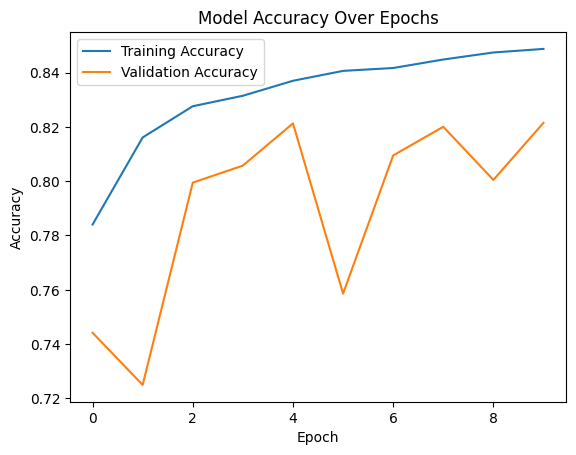

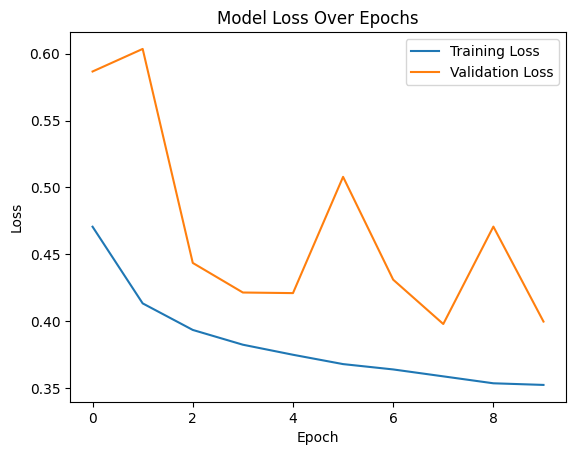

In [22]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()


## Generating Predictions and Submitting Results to Kaggle

In this final step, we use the trained model to make predictions on the test dataset and create a **submission file** (`submission.csv`) for Kaggle.

### Steps in This Process:
1. **Load the Test Images**:
   - Read all images from the `test/` directory.
   - Resize them to match the model’s input size (50x50 pixels).
   - Normalize pixel values to the range `[0,1]` for consistency with training data.

2. **Make Predictions**:
   - Use the trained model to predict whether each image contains cancerous cells.
   - The model outputs probability scores in the range `[0,1]`.
   - Convert these probabilities into binary labels (`1` for cancerous, `0` for non-cancerous) using a threshold of **0.5**.

3. **Prepare the Submission File**:
   - Store the test image IDs and corresponding predictions in a Pandas DataFrame.
   - Save the predictions as a `.csv` file in the required Kaggle format.

### Expected Output:
- A CSV file named **`submission.csv`** with two columns:
  - `id`: The image ID from the test dataset.
  - `label`: The predicted class (`0` or `1`).


In [23]:
# Define test directory path
TEST_DIR = os.path.join(DATA_DIR, "test")
test_images = []
test_ids = []

# Load test images
for file_name in os.listdir(TEST_DIR):
    image_path = os.path.join(TEST_DIR, file_name)
    img = load_img(image_path, target_size=(50, 50))  # Resize to 50x50
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    test_images.append(img_array)
    test_ids.append(file_name.split('.')[0])  # Extract image ID

# Convert to NumPy array
X_test = np.array(test_images)

# Make predictions
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

# Create submission DataFrame
submission = pd.DataFrame({"id": test_ids, "label": predictions})

# Save as CSV file
submission.to_csv("submission.csv", index=False)

print("Predictions completed. 'submission.csv' has been generated.")


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Predictions completed. 'submission.csv' has been generated.


## Discussion and Conclusion

### Summary of Results
The CNN model was trained using a dataset of histopathologic images to classify cancerous vs. non-cancerous tissues. The following key observations were made:
- **Accuracy & Loss Trends:**
  - The training accuracy increased consistently, while validation accuracy stabilized after a few epochs.
  - If the training accuracy is significantly higher than the validation accuracy, overfitting may be present.
- **Performance on the Test Set:**
  - Predictions were generated on the test set, and the submission file was created for Kaggle evaluation.

### Potential Model Improvements
While the model achieves reasonable accuracy, further improvements could be made:
1. **Data Augmentation**: Additional techniques such as brightness adjustment or contrast augmentation could be used.
2. **More Complex Architectures**: Trying deeper networks such as **ResNet** or **EfficientNet** may improve classification performance.
3. **Hyperparameter Tuning**: Experimenting with different learning rates, batch sizes, and optimizers.
4. **Class Imbalance Handling**: If the dataset is imbalanced, methods like **class weighting** or **oversampling** could be implemented.

### Final Thoughts
This project demonstrates the ability of **Convolutional Neural Networks (CNNs) to classify histopathologic cancer images**.
Further improvements in model tuning and dataset preprocessing may yield even better results.
